# genereative model 

In [1]:
from brian2 import *
%matplotlib inline
from brian2 import SpikeGeneratorGroup
from brian2 import NeuronGroup
import numpy as np
import random
import pandas as pd

faire un modele generatif où on aurait : 
- une première couche de i neurones = nb de PGs 
- une deuxième couche où on aurait j neurones, connectés à tous les i qui génèrent des PGs en réponse à un spike émit par un i 

on aurait donc {i, j} avec par ex i emet un spike à 10ms et connecte les neurones j1, j3 et j4 qui émettent des spikes à 10ms, 15ms et 6ms respectivement 

-> on définit donc par ti le timing d'occurence d'un PG et par tj le pattern du PG

### variable definition

In [2]:
Ni = 10 #nb de PGs différents
Nj = 10 #nb de N
n_pattern = 30 # nb d'occurrence des PGs 
duration = 100000*ms

PGs_pattern = {}
PGs_id_tps = {}

a = np.arange(Ni)
cmap = plt.cm.get_cmap("plasma")
color_dict = pd.Series({i:cmap(i/len(a)) for i,k in enumerate(a)})

In [3]:
# --- def du moment d'occurence des PGs -------------------------------------------------------------------------------------------------

i_indices = np.random.randint(0, Ni, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
i_temps = np.random.uniform(0, duration, size = n_pattern)*ms # temps d'occurence des n_pattern PG 


# --- def des projections des neurones pré-syn (i.e. des des PGs) -----------------------------------------------------------------------

i_syn=[]
n_syn = []

for k in range(Ni) : 
    n_j = np.random.randint(3, Nj, size = 1) # nombre de neurone qu'un Ni va connecter : au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def les j connectés à i[k], pas de repetition, nb def au hasard par n_j (>3)
    n_syn.append(len(i_syn[k])) # pour set des poids et délais aléatoires aux synapses, voir ci-après 

n_syn = sum(n_syn) 


# --- def des poids et delais synaptiques -----------------------------------------------------------------------------------------------

weight = np.random.rand(n_syn)
delay = np.random.rand(n_syn)*0.1*second

### NN simulation for PGs generation 

In [22]:
for i in range(n_pattern) :
    c = SpikeGeneratorGroup(Ni, [i_indices[i]], [i_temps[i]/ms*msecond])
    c_spike= SpikeMonitor(c)
    
    d = NeuronGroup(Nj, '''dv/dt = -v/tau : volt
                       tau : second''',
                    threshold= 'v > 0.01*volt',
                    reset= 'v = -0.07*volt',
                    method = 'exact')
    
    d.tau = 0.01*second
    d_spike = SpikeMonitor(d)

    s = Synapses(c,d, on_pre='v+=0.1*w*volt', model = 'w:1')
    
    for k in range(Ni):
        s.connect(i = k , j = i_syn[k])
               
    s.w[:,:] = weight
    s.delay[:,:] = delay
    
    run(duration)
    
    PGs_id_tps[i] = (c_spike.t, c_spike.i)
    PGs_pattern[i] = (d_spike.t, d_spike.i) # je vourdrais avoir l'echelle de temps en ms et non en s 
    

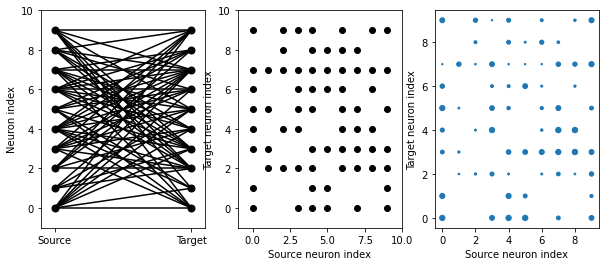

In [29]:
def visualise_connectivity(syn): # ajouter les delays
    Ns = len(syn.source)
    Nt = len(syn.target)
    figure(figsize=(10, 4))
    subplot(131)
    plot(zeros(Ns), arange(Ns), 'ok', ms=7)
    plot(ones(Nt), arange(Nt), 'ok', ms=7)
    for i, j in zip(syn.i, syn.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(132)
    plot(syn.i, syn.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    subplot(133) 
    scatter(syn.i, syn.j, syn.w*30 )
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(s)

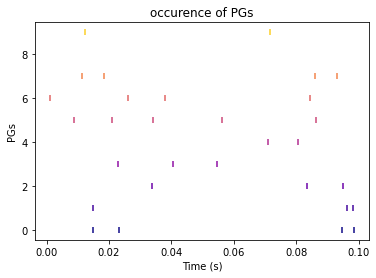

In [30]:
for i in range(n_pattern) :
    plt.scatter(PGs_id_tps[i][0], PGs_id_tps[i][1], color = color_dict[i_indices[i]], marker = "|")
    xlabel('Time (s)')
    ylabel('PGs')
    title('occurence of PGs')

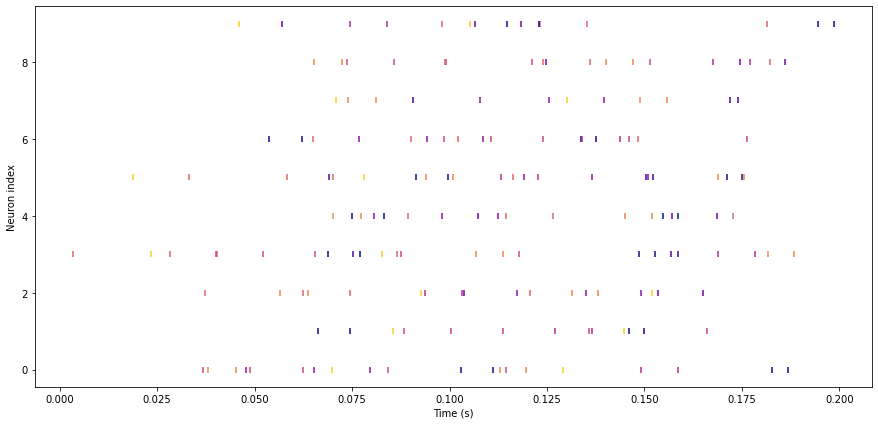

In [31]:
all_PGs_pattern = []
plt.figure(figsize=(15,7))
for i in range(n_pattern) :
    plt.scatter(PGs_pattern[i][0], PGs_pattern[i][1], color = color_dict[i_indices[i]], marker = "|")
    xlabel('Time (s)')
    ylabel('Neuron index');

# unsupervised recognition of PGs

## '' detection ''of temporal patterns 

In [54]:
# obtenir le temps de chaque spike, dans l'ordre d'apparition, indépendemment du PGs auquel il appartient
all_spike_time = []

for k in range(n_pattern) :
    for i in range(len(PGs_pattern[k][1])):
        all_spike_time.append(tuple((round(PGs_pattern[k][0][i]/second*1000), PGs_pattern[k][1][i])))
        
all_spike_time.sort(key=lambda y: y[0])

In [12]:
# def de ma fenetre temporelle pour reconnaître les PGs
t_window = 150
X_1 = np.zeros((Nj, t_window))# shape = Nj, 150ms
X_2 = np.zeros((Nj, t_window)) 
X_3 = np.zeros((Nj, t_window)) 

# autre solution : X = np.zeros((duration/150,Nj, t_window))

In [69]:
for j, (t,i) in enumerate(all_spike_time) : 
    if t<15 : 
        X_1[i][t] = 1
        #print('ok')
    if 15<t<30 : 
        X_2[i][t] = 1
        print('ok')
    if 30<t<45:
        X_3[i][t] = 1
        #print('ok')

ok
ok
ok


In [67]:
for i in X_2 : 
   # if i == 1:
    print(i)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

In [66]:
all_spike_time

[(3, 3),
 (19, 5),
 (24, 3),
 (28, 3),
 (33, 5),
 (37, 2),
 (37, 0),
 (38, 0),
 (40, 3),
 (40, 3),
 (45, 0),
 (46, 9),
 (48, 0),
 (49, 0),
 (52, 3),
 (54, 6),
 (56, 2),
 (57, 9),
 (58, 5),
 (62, 0),
 (62, 2),
 (62, 6),
 (64, 2),
 (65, 6),
 (65, 8),
 (65, 0),
 (66, 3),
 (66, 1),
 (69, 5),
 (69, 3),
 (70, 0),
 (70, 5),
 (70, 4),
 (71, 7),
 (72, 8),
 (74, 2),
 (74, 8),
 (74, 1),
 (74, 7),
 (74, 9),
 (75, 3),
 (75, 4),
 (77, 4),
 (77, 3),
 (77, 6),
 (78, 5),
 (80, 0),
 (80, 4),
 (81, 7),
 (83, 4),
 (83, 3),
 (84, 9),
 (84, 0),
 (86, 1),
 (86, 8),
 (87, 3),
 (88, 1),
 (88, 3),
 (89, 4),
 (90, 6),
 (91, 7),
 (91, 5),
 (93, 2),
 (94, 5),
 (94, 2),
 (94, 6),
 (98, 9),
 (98, 6),
 (98, 4),
 (99, 8),
 (99, 8),
 (100, 1),
 (100, 5),
 (101, 5),
 (102, 6),
 (103, 2),
 (103, 0),
 (104, 2),
 (105, 9),
 (107, 4),
 (107, 3),
 (107, 9),
 (108, 6),
 (108, 7),
 (111, 6),
 (111, 0),
 (112, 4),
 (113, 0),
 (113, 5),
 (114, 1),
 (114, 3),
 (114, 4),
 (115, 0),
 (115, 9),
 (116, 5),
 (117, 2),
 (118, 9),
 (118

## cam's k-means